Exercise 5: Variance reduction methods Exercise 5: Variance reduction methods

1. Estimate the integral   $\int \limits _0 ^{1} e^{ x } dx $ by simulation (the crude Monte Carlo
estimator). Use eg. an estimator based on 100 samples and present
the result as the point estimator and a confidence interval.

2. Estimate the integral $\int \limits _0 ^{1} e^{ x } dx $ using antithetic variables, with
comparable computer ressources.
3. Estimate the integral  $\int \limits _0 ^{1} e^{ x } dx $ using a control variable, with
comparable computer ressources.

4. Estimate the integral $\int \limits _0 ^{1} e^{ x } dx $ using stratified sampling, with
comparable computer ressources.

5. Use control variates to reduce the variance of the estimator in
exercise 4 (Poisson arrivals).


6. Demonstrate the effect of using common random numbers in
exercise 4 for the difference between Poisson arrivals (Part 1) and a
renewal process with hyperexponential interarrival times. Remark:
You might need to do some thinking and some re-programming.


7. For a standard normal random variable Z ∼ N(0, 1) using the crude
Monte Carlo estimator estimate the probability Z > a. Then try
importance sampling with a normal density with mean a and
variance σ2. For the expirements start using σ2 = 1, use different
values of a (e.g. 2 and 4), and different sample sizes. If time
permits experiment with other values for σ2. Finally discuss the
efficiency of the methods.

8. Use importance sampling with g(x) = λ exp (−λ ∗ x) to calculate
the integral $\int \limits _0 ^{1} e^{ x } dx $ 
 of Question 1. Try to find the optimal value of
λ by calculating the variance of h(X)f(X)/g(X) and verify by
simulation. Note that importance sampling with the exponential
distribution will not reduce the variance.

9. For the Pareto case derive the IS estimator for the mean using the
first moment distribution as sampling distribution. Is the approach
meaningful? and could this be done in general? With this insight
could you change the choice of g(x) in the previous question
(Question 8) such that importance sampling would reduce the
variance? You do not need to implement this, as long as you can
argue, what should happen.

In [16]:
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import time


In [17]:
U = np.random.uniform(0,1,100)

# 1

In [18]:
def crude_monte_carlo_estimator(u):
    n = len(u)
    X = np.exp(u)
    mean = np.mean(X)
    
    S_square = (1/(n-1)) * (np.sum(np.multiply(X, X)) - n * mean ** 2)
    S = math.sqrt(abs(S_square))
    monte_conf_interval = [mean + (S / math.sqrt(n)) * stats.t.ppf(0.025, n-1), mean + (S / math.sqrt(n)) * stats.t.ppf(1-0.025, n-1)]
    print('Monte Carlo estimates of Mean: {} with confidence interval {}'.format(mean, monte_conf_interval))


In [19]:
crude_monte_carlo_estimator(U)

Monte Carlo estimates of Mean: 1.7417975376156634 with confidence interval [1.6374697195943884, 1.8461253556369384]


# 2

In [20]:
def antithetic_variables(u):
    n = len(u)
    Y = (np.exp(u) + np.e / np.exp(u)) / 2
    Ybar = np.mean(Y)

    X1 = np.exp(u)
    X1bar = np.mean(X1)
    X1var = np.var(X1)

    u1 = 1 - np.array(u)
    X2 = np.exp(u1)
    X2bar = np.mean(X2)
    X2var = np.var(X2)

    Yvar = 0.5 * (X1var + np.e - X1bar * X2bar)
    Ybar_conf = 1.96 * math.sqrt(abs(Yvar)) / math.sqrt(n)
    ant_conf_interval = [Ybar - Ybar_conf, Ybar + Ybar_conf]
    print('Antithetic variables estimates of Mean: {} and confidence interval {}'.format(Ybar, ant_conf_interval))


In [21]:
antithetic_variables(U) 

Antithetic variables estimates of Mean: 1.7248081682812069 and confidence interval [1.7065811603962513, 1.7430351761661624]


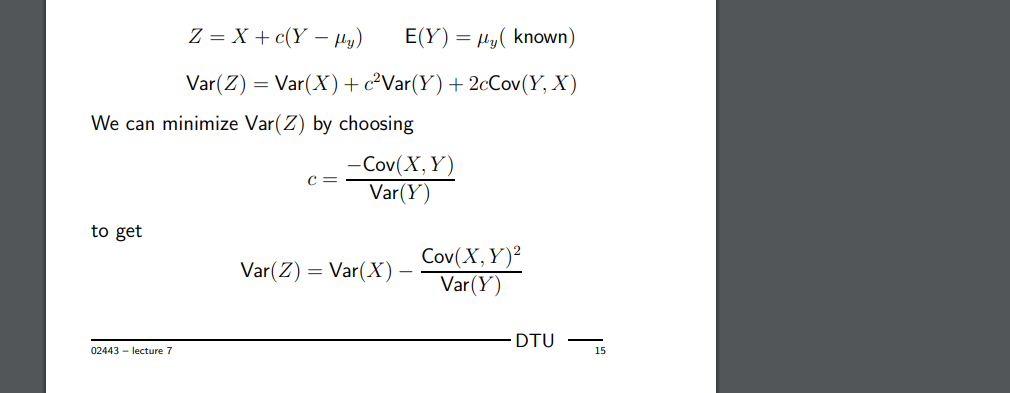

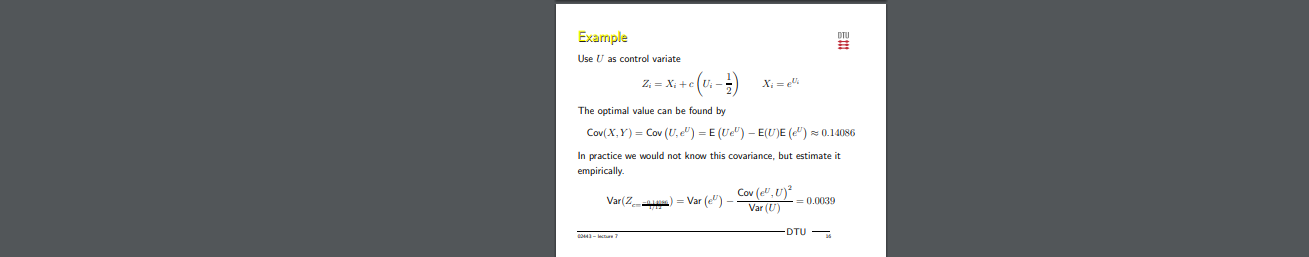

# 3

In [38]:
def control_variables(u):
    n = len (u)
    X = np.exp(u)
    Y = u
    Yminus_half = []
    for x in Y:
        Yminus_half.append(x - 0.5)
    
    XY = np.multiply(X,Y)
    Xmean, Xvar = np.mean(X), np.var(X)
    Ymean, Yvar = np.mean(Y), np.var(Y)
    XYmean, XYvar = np.mean(XY), np.var(XY)
    Cov_XY = XYmean - Xmean * Ymean
    c = -Cov_XY / Yvar
    
    Z = X + np.multiply(c,Yminus_half)
    Zmean = sum(Z)/n
    Zvar = Xvar - (Cov_XY **2/Yvar)
    
    
    Zmean_conf = 1.96 * math.sqrt(Zvar)/math.sqrt(n)
    control_conf_interval = [Zvar - Zmean_conf, Zmean + Zmean_conf]
    
    print('Control variables estimates of Mean: {} with confidence interval {}'.format(Zmean, control_conf_interval))
    


In [39]:
control_variables(U)

Control variables estimates of Mean: 1.725222919410543 with confidence interval [-0.008499074508624763, 1.7379157971801724]


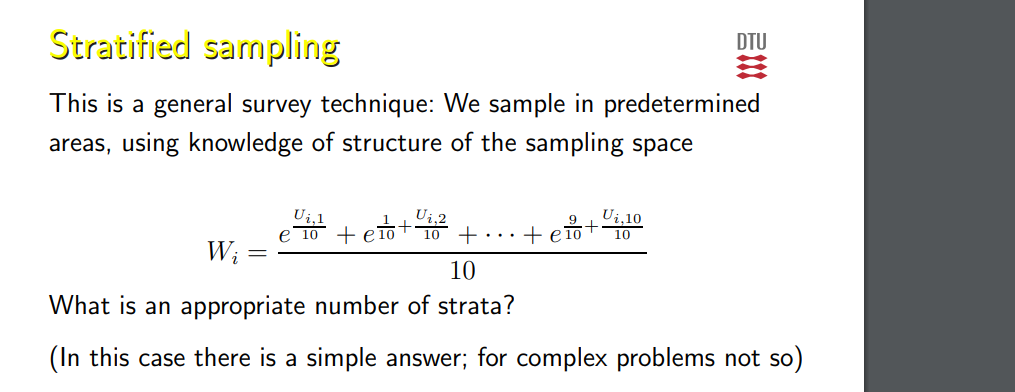

In [ ]:
U = np.random.rand(int(math.sqrt(N)), int(math.sqrt(N)))

W = np.zeros((int(math.sqrt(N)), 1))
for i in range(int(math.sqrt(N))):
for j in range(int(math.sqrt(N))):
W[i] = W[i] + math.exp((U[i, j] + (j - 1)) / 10)
W[i] = W[i] / 10



# 4


In [44]:
def stratified_sampling(u):
    N = len(u)
    u_reshaped = np.reshape(u, (int(math.sqrt(N)), int(math.sqrt(N))))
    w = np.zeros((int(math.sqrt(N)), 1))
    for i in range(int(math.sqrt(N))):
        for j in range(int(math.sqrt(N))):
            w[i] = w[i] + math.exp((u_reshaped[i, j] + (j - 1)) / 10)
            w[i] = w[i] / 10
            
    Wmean, Wvar = np.mean(w), np.var(w)
    
    Zmean_conf = 1.96 * math.sqrt(Wvar) / math.sqrt(N)
    stratified_conf_interval = [Wmean - Zmean_conf, Wmean + Zmean_conf]
    
    print('Stratified sampling estimates of Mean: {} with confidence interval {}'.format(Wmean, stratified_conf_interval))

In [45]:
stratified_sampling(U)

Stratified sampling estimates of Mean: 0.26165082690696384 with confidence interval [0.2606418602066851, 0.26265979360724256]


# 5